In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = "../data/case_study_data_final.csv"
click_data = pd.read_csv(data_path).drop("index", axis=1)

In [4]:
click_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  15000 non-null  int64  
 1   district              15000 non-null  int64  
 2   min_booking_duration  15000 non-null  int64  
 3   first_pic_category    13697 non-null  object 
 4   beds                  15000 non-null  int64  
 5   rooms                 15000 non-null  int64  
 6   deposit               15000 non-null  float64
 7   area                  13301 non-null  float64
 8   price                 14999 non-null  float64
 9   accommodates          13268 non-null  float64
 10  number_of_pics        13702 non-null  float64
 11  cleaning_fee          13450 non-null  float64
 12  clicks                15000 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 1.5+ MB


In [5]:
click_data.sample(5)

,city,district,min_booking_duration,first_pic_category,beds,rooms,deposit,area,price,accommodates,number_of_pics,cleaning_fee,clicks
3064,888,984,1,LIVING_DINING_ROOM,1,1,1100.0,37.0,1100.0,2.0,7.0,150.0,1118
12148,888,984,6,LIVING_ROOM,1,1,1580.0,30.0,790.0,2.0,15.0,120.0,173
1056,465,567,3,FLOOR_PLAN,1,2,500.0,71.0,1300.0,2.0,1.0,0.0,0
3544,712,819,3,OUTDOOR_HOUSE,0,5,5200.0,134.0,2600.0,6.0,11.0,180.0,117
7768,141,576,1,LIVING_DINING_ROOM,1,2,3000.0,60.0,1949.0,2.0,40.0,200.0,0


### Explore Label

Label Descriptions

In [6]:
click_data[["clicks"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
clicks,15000.0,368.127533,934.179019,0.0,0.0,87.0,468.0,38458.0


More than 40% of the data have clicks equal to 0

In [7]:
len(click_data[click_data.clicks==0])/len(click_data)

0.4018

Checking Skew and Kurtosis

In [8]:
print("Skewness: %f" % click_data['clicks'].skew())
print("Kurtosis: %f" % click_data['clicks'].kurt())

Skewness: 15.783485
Kurtosis: 433.027260


### Explore full Data

In [9]:
counts = pd.DataFrame(click_data.nunique()).reset_index()
counts.columns = ["features", "unique_values"]
counts

,features,unique_values
0,city,905
1,district,957
2,min_booking_duration,19
3,first_pic_category,31
4,beds,17
5,rooms,14
6,deposit,814
7,area,377
8,price,1155
9,accommodates,20


### Create a Description Data containing Missing values Unique values and Types 

In [10]:
click_data["city"] = click_data["city"].astype(object)
click_data["district"] = click_data["district"].astype(object)

def get_column_type(col):
    return str(click_data[col].dtype)
total = click_data.isnull().sum().sort_values(ascending=False)
percent = (click_data.isnull().sum()/click_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total_missing', 'ratio_missing']).reset_index()
missing_data.columns = ["features", "total_missing", "ratio_missing"]
description = pd.merge(missing_data, counts, on="features")
description["type"] = description["features"].apply(get_column_type)
description.sort_values(by = "type")

,features,total_missing,ratio_missing,unique_values,type
0,accommodates,1732,0.115467,20,float64
1,area,1699,0.113267,377,float64
2,cleaning_fee,1550,0.103333,161,float64
4,number_of_pics,1298,0.086533,90,float64
5,price,1,0.000067,1155,float64
11,deposit,0,0.000000,814,float64
8,min_booking_duration,0,0.000000,19,int64
9,beds,0,0.000000,17,int64
10,rooms,0,0.000000,14,int64
12,clicks,0,0.000000,1943,int64


City, District and first_pic_category are categorical

### Correlation Study

<AxesSubplot:>

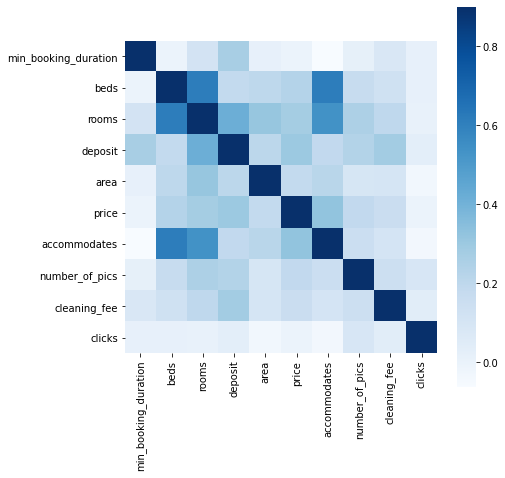

In [11]:
corr = click_data.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

Some interesting correlations:
* beds and accomodates
* rooms and beds

No correlation found between any feature and clicks

### Managing Categorical Features

### City

In [17]:
city_clicks = click_data.groupby("city").agg({"clicks" : "sum"}).sort_values(by="clicks", ascending = False)
city_clicks.head(15)

,clicks
city,
141,2661507
465,353659
822,347706
271,276156
349,226812
656,171951
888,99248
701,91237
1194,85243


<AxesSubplot:xlabel='city', ylabel='clicks'>

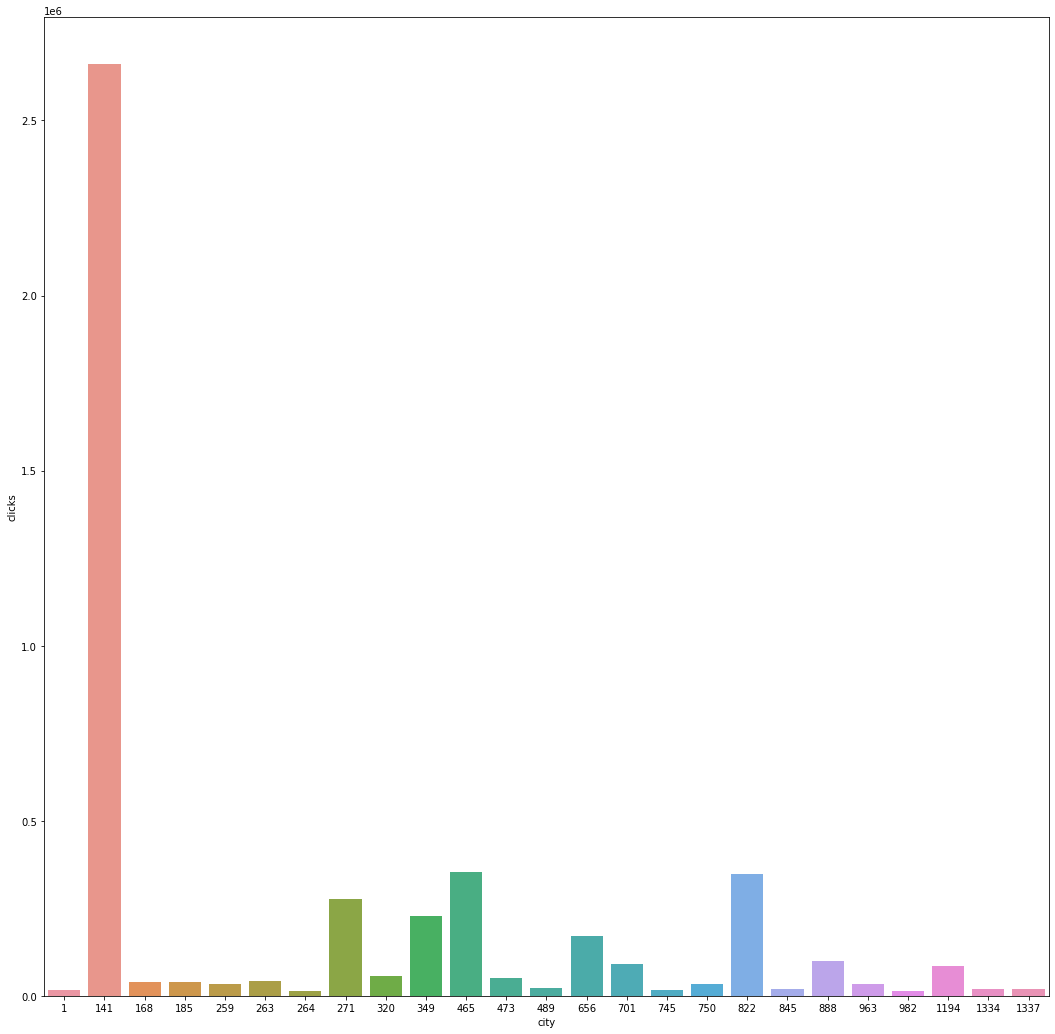

In [29]:
plt.subplots(figsize=(18,18))
sns.barplot(x = city_clicks.head(25).index, y = city_clicks.head(25).clicks)